In [143]:
# N digit Quantum Multiplier (Task 1)
# Author: Matthew Prest
# Email: mtp354@nyu.edu
# Made for the entry task of Cohort 6 in the Quantum Open Source Foundation Mentorship Program.

# Import Statements.
import numpy as np
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister, transpile, Aer
from qiskit.circuit.library import QFT, PhaseGate

# Some helper functions that operate within the multiplier.

# Convert number to binary string.
def switch_int_bin_str(num, digits=3):
    """Converts ints to binary strings and vice-versa.

    Args:
        num (int or str): input to be converted.
        digits (int, optional): Number of digits needed to represent number in binary. Defaults to 3.

    Returns:
        str or int: converted input.
    """
    if isinstance(num, int):
        return f'{num:0{digits}b}'
    elif isinstance(num, str):
        return int(num, 2)

# Set input state function.
def set_input(a, b, digits=3):
    """Prepare a quantum circuit with initial input values a and b.
    Args:
        a (int): multiplicand/multiplier.
        b (int): multiplicand/multiplier.
    Returns:
        QuantumCircuit: An initialized quantum circuit with two input quantum registers,
        a product quantum register initialized in |0> and a classical register.
    """
    r_a = QuantumRegister(digits, 'a')
    r_b = QuantumRegister(digits, 'b')
    r_0 = QuantumRegister(2*digits, 'p')  # Product output, initialized as 0.
    cr = ClassicalRegister(2*digits, 'c')
    qc = QuantumCircuit(r_a, r_b, r_0, cr)
    binary_pair = zip(switch_int_bin_str(a, digits), switch_int_bin_str(b, digits), strict=True)
    
    # looping through and applying X gates to flip bits.
    for index, strings in enumerate(binary_pair):
        if strings[0] == '1':
            qc.x(r_a[digits-1-index])
        if strings[1] == '1':
            qc.x(r_b[digits-1-index])
    return qc, r_a, r_b, r_0, cr


# Quantum multiplier primary function.
def quantum_multiplier(a, b):

    # Initializing Circuit.
    digits = max(len(bin(a)[2:]), len(bin(b)[2:]))
    qc, r_a, r_b, r_0, cr = set_input(a, b, digits=digits)

    # Applying QFT to 0 initialized product state.
    qc.append(QFT(2*digits, do_swaps=False), np.arange(2*digits, 4*digits).tolist())

    # Looping through applying twice conditional PhaseGates, using design in Ruiz-Perez, Garcia-Escartin
    # Functions as repeated addition of a, looped over b with carrying based on qubit position in b.
    for i in range(1, digits + 1):
        for j in range(1, digits + 1):
            for s in range(1, 2*digits + 1):
                qc.append(PhaseGate(2*np.pi/(2**(i+j+s-2*digits))).control(2),
                [r_a[digits-i],r_b[digits-j],r_0[s-1]])

    # Converting product back from Fourier basis to computational basis.
    qc.append(QFT(2*digits, do_swaps=False).inverse(), np.arange(2*digits, 4*digits).tolist())

    # Measuring the product registry in the computational basis.
    qc.measure(r_0, cr)

    # Running the quantum circuit on a simulator.
    simulator = Aer.get_backend('aer_simulator')
    compiled_circuit = transpile(qc, simulator)
    job = simulator.run(compiled_circuit, shots=100)

    # Extract results and return product.
    result = job.result()
    counts = list(result.get_counts(compiled_circuit))[0]
    return switch_int_bin_str(counts, digits)
    


In [ ]:
# Some illustrative examples of a working multiplier:
print(quantum_multiplier(5, 6))
print(quantum_multiplier(0, 3))
print(quantum_multiplier(9, 4))
print(quantum_multiplier(4, 9))
print(quantum_multiplier(8, 1))
print(quantum_multiplier(7, 11))

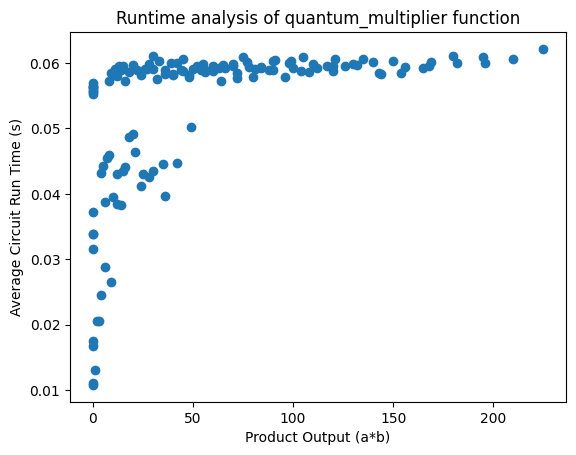

In [201]:
# Bonus: Performance analysis of my quantum_multiplier algorithm.
# Larger a, b increases number of phase gates needed (circuit depth).
# Using the %timeit magic commands we can explore the effect on run time.

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


def get_runtime(x, y):
    rt = %timeit -q -o quantum_multiplier(x, y)
    return rt.average

times = []
max_input = 16

for x in range(0, max_input):
    for y in range(x, max_input):
        times.append((x*y, get_runtime(x, y)))

plt.scatter(*zip(*times))
plt.xlabel("Product Output (a*b)")
plt.ylabel("Average Circuit Run Time (s)")
plt.title("Runtime analysis of quantum_multiplier function")
plt.show()
